<a href="https://colab.research.google.com/github/sjosephnyc1987/public_ipython_Notebooks/blob/main/SJoseph_MasteWorks_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment** - The team is interested in understanding the following:

**1.** 	Using Price divided by Low Estimate (called the PLE ratio) as a metric of beating expectations, what is the relationship between that and the dollar value of the low estimate?

**2.**	Is the PLE ratio correlated with the order that a lot is auctioned? Do earlier lots perform better than those that come later?


#Imports and Data pre-processing
Real-world data typically contains noise, missing values, and may be in an unsuitable format, making it impossible to apply models directly on it. Data preprocessing is a necessary task for clearing the data and preparing it for machine learning models, which also improves the model's accuracy and effectiveness.

In [ ]:
!pip install requests

In [ ]:
#imports
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#for non-linear regression
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

#reading in the date as a CSV file into Pandas dataFrame
url = 'https://raw.githubusercontent.com/sjosephnyc1987/datasets/main/StephenJoseph-case_study_vp_analytics.csv'
df = read_csv(url)


In [ ]:
#importing a custom non-linear regression library i wrote
#see more here https://github.com/sjosephnyc1987/funcspinner

import requests
cust_url = 'https://raw.githubusercontent.com/sjosephnyc1987/funcspinner/main/funcspinner.py'
r = requests.get(cust_url)

# make sure your filename is the same as how you want to import 
with open('funcspinner.py', 'w') as f:
    f.write(r.text)

# now we can import
import funcspinner 

In [ ]:
#Data Clean-up
#lot_numbers are not labelled consistently and so we're cleaning that up

old_list=[]
new_list=[]

for i in range(101,159):
    old_list.append(i)
    new_list.append(i-100)

df['lot_number']= df['lot_number'].replace(old_list,new_list)


In [ ]:
#let's see if our clean-up worked.
df['lot_number'].describe()

count    230.000000
mean      25.226087
std       15.368863
min        1.000000
25%       12.000000
50%       24.000000
75%       37.000000
max       58.000000
Name: lot_number, dtype: float64

In [ ]:
#Dropping rows with empty fields (NAs) - there are some price fields that are empty and so we're going to drop them. But let's also make sure we're not dropping too much of that.
print("length of df = ", len(df))
print("length of dropped na_df = ", len(df.dropna()))
df = df.dropna()
print("new length of df = ", len(df))


length of df =  230
length of dropped na_df =  215
new length of df =  215


In [ ]:
#Next we Creatre the PLE column
df['PLE'] = df['price_usd']/df['low_estimate_usd']

#and look at the final dataframe before starting our analysis
df.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,lot_number,price_usd,low_estimate_usd,high_estimate_usd,PLE
count,215.000000,2.150000e+02,2.150000e+02,2.150000e+02,215.000000
mean,24.730233,2.210768e+06,1.508808e+06,2.148423e+06,2.072129
std,15.520314,6.698696e+06,4.878640e+06,6.658543e+06,2.430217
min,1.000000,2.256500e+04,1.160500e+04,1.547300e+04,0.845000
25%,11.500000,2.970450e+05,1.295950e+05,2.000000e+05,1.166580
50%,23.000000,6.523820e+05,4.000000e+05,6.220580e+05,1.476944
75%,37.000000,1.732067e+06,1.000000e+06,1.500000e+06,2.111752
max,58.000000,8.455000e+07,6.000000e+07,8.000000e+07,30.333333


#Model Selection
We need to decide what model to use for the task at hand. While, this is not a classification problem, neither is it a clusering or time-series problem. Furthermore, I imagine, the model will require a high degree of exlpainability and since both of our variables (PLE & Low Estimate) are continueous, we are left with Regression, Descision Trees and Random Forests as possible choices.

Random forests have problem with predicting out-of-sample data and so don't seem very useful here, they also hard to explain to a general audience and so we need look at the other choices. Descison-tree regression is more useful in predicting the outcome, rather than describing the relationship between the two variables and so that leaves us with Regression, (both linear and non-linear).

**Regression** has been around for a while, is well studied for many edge-cases, easy to understand and perfectly suited to suited the relationship between two continueous variables. Our model of choice is thus Regression.




In [ ]:
#Let's start off doing a simple regression from ScikitLearn

X=np.array(df['PLE']).reshape((-1,1))
y=np.array(df['low_estimate_usd'])

model = LinearRegression().fit(X, y)
r_sq = model.score(X, y)

#Sci-kit learn does not give us Standard Error and so we have to calulate that ourselves.
#First we calculate the residuals in order to get the standard error
prediction = model.predict(X)
residuals = (y - prediction)

#then we calculate RMSE
squaresumofresiduals = np.sum(residuals**2) 
std_error = np.sqrt(squaresumofresiduals/len(prediction))
print("standard error manually calculated from scikit_learn = ", str(std_error))

#regression coeffiecents
print('coefficient of determination R-sq:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)


standard error manually calculated from scikit_learn =  4852606.3201466985
coefficient of determination R-sq: 0.006020694572487328
intercept: 1831578.2807378164
slope: [-155767.52066177]


### Interpreting Results
**R-Squared** tells us how well the regression model fits the data (R-Squared is between 0 & 100%). 

*The the R-square here is pretty low but that does not tell us the complete story, we need to look at RMSE and p-value as well.*

**RMSE** is the square root of the variance of the residuals. It is the standard deviation of the residuals (prediction errors). It is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit.

*RMSE has the same unit as the dependent variable (DV). It means that there is no absolute good or bad threshold, however you can define it based on your DV.

(For a data which ranges from 0 to 1000, an RMSE of 0.7 is small, but if the range goes from 0 to 1, it is not that small anymore. However, although the smaller the RMSE, the better)

*The RMSE here is "off the charts" and so the model is **not** all that good at predicting*

Next let's look at the results visually and then let's look at the p-value


Text(0.5, 1.0, 'PLE vs low_estimate_usd')

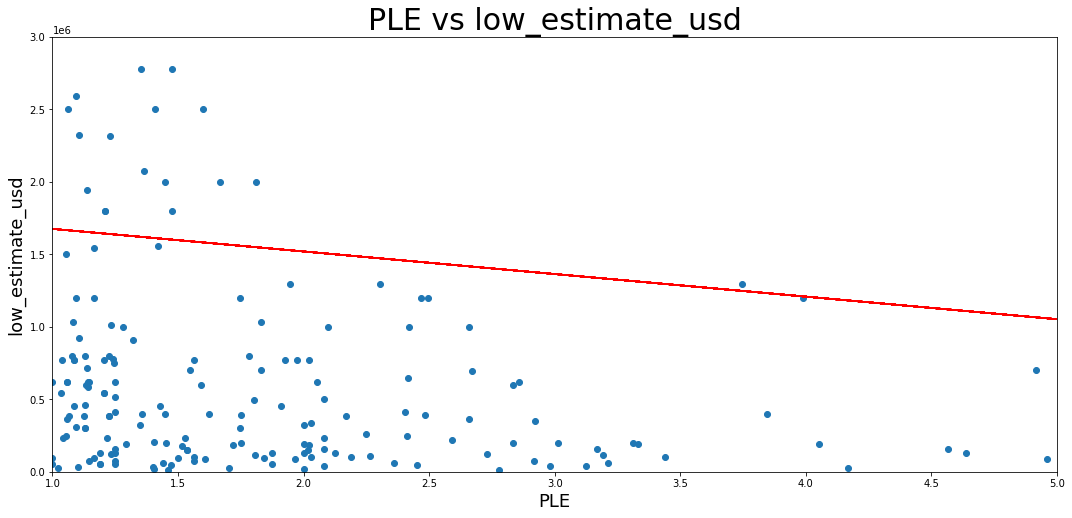

In [ ]:
#plotting PLE vs the low-estimate as a scatter plot (blue)
fig, ax = plt.subplots(figsize=(18,8))
ax.scatter(X, y)
ax.set_xlim(1, 5)
ax.set_ylim(0, 3000000);
ax.set_xlabel("PLE",fontsize=18)
ax.set_ylabel("low_estimate_usd",fontsize=18)

#plotting the regression line in red
plt.plot(X, model.predict(X),color='r')
plt.title("PLE vs low_estimate_usd", fontsize=30)

#plt.scatter(y, X, color='r')
#plt.plot(y, X, color='r')

Its clear from the picture above that the line is slightly negatively sloped and that there's not paricularly a good fit (which is also what we gather from the RMSE)

Next let's look at the p-values of the variables. This is much easier done in statsmodels. We'll also use statsmodel to verify the results we get in scikit-learn.

In [ ]:
#Let's verify this using statmodels
print("\n-------------using statsmodels--------------")

import statsmodels.api as sm

#getting some nwew varibles 
xx = df['PLE']
yy = df['low_estimate_usd']

h = np.array(xx)
w = np.array(yy)

#to make statsmodels work, you have to add a constant to X
h = sm.add_constant(h)

model2 = sm.OLS(w, h) #note that the x and y are inverted here.
results2 = model2.fit()
print(results2.summary())

std_error_model = np.sqrt(results2.scale)
print("standard error from stats_models = ", std_error_model)



-------------using statsmodels--------------
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.290
Date:                Sun, 25 Sep 2022   Prob (F-statistic):              0.257
Time:                        03:17:01   Log-Likelihood:                -3615.0
No. Observations:                 215   AIC:                             7234.
Df Residuals:                     213   BIC:                             7241.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

R-Squared and RMSE are same as scikit-learn, so we've re-verified that. *p-value (or probability value), is a number describing how likely it is that your data would have occurred by random chance (i.e. that the null hypothesis is true). The p-value is the evidence against a null hypothesis.

You get a p-value for each variable that you compare against the Significance levels.

*our p-value here is 0.257 which is pretty high and so our x variable is pretty random, and so we reject the null-hypothesis*


## Correlation
Regression is an advanced form of pearson-correlation and so doing a correlation study between the two variables is not going to be "more" insightful. However, correlation is pretty easy to perform in pandas and so we run a standard correlation between the two dimensions to see if it supports our regression conclusions.

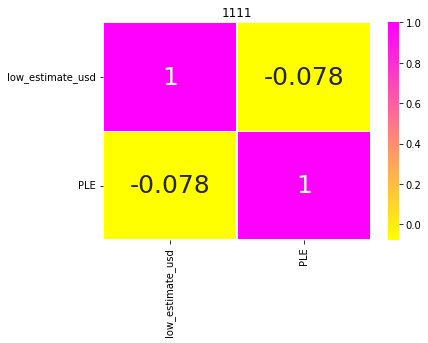

In [ ]:
#correlation
corr_matrix_inputs = df[['low_estimate_usd','PLE']]
corr_matrix = corr_matrix_inputs.corr()

sns.heatmap(data=corr_matrix, annot=True, cmap="spring_r", linewidths=0.3, annot_kws={"size": 25}).set(title='1111')
#Plot aesthetics
plt.xticks(rotation=90)
plt.yticks(rotation=0) 
plt.show()

our results here echo what we see in Regression - the two variables are directionally negatively correlated, but magnitute is almost zero (uncorrelated)

##Lot Number
Next we try to answer the second question  - *Is the PLE ratio correlated with the order that a lot is auctioned? Do earlier lots perform better than those that come later?*

We group the PLE values by mean around the lot_number and plot the results in a bar-chart.

Text(0.5, 1.0, 'PLE vs lot_number')

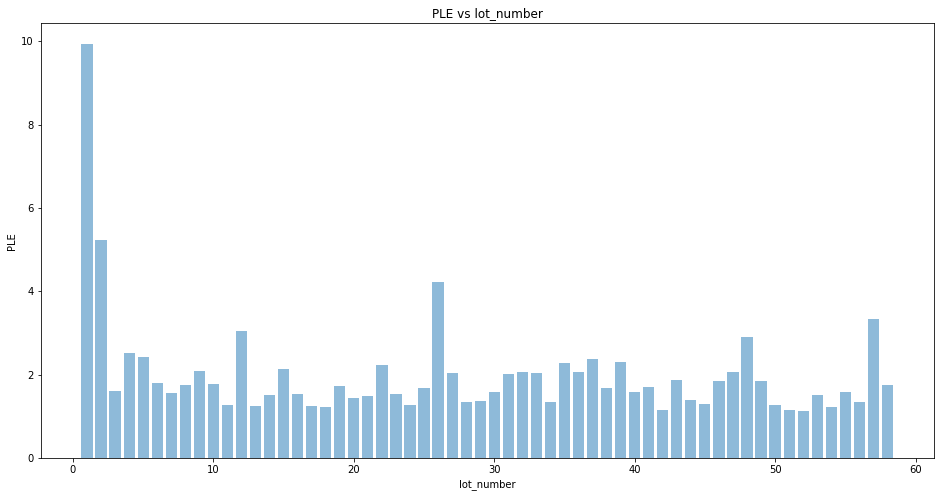

In [ ]:
#Does lot_number mean anythign
dfg = df.groupby(['lot_number']).mean()['PLE']
#dfg.plot(kind='bar')

fig2, ax2 = plt.subplots(figsize=(16,8))
#dfg.bar(
plt.bar(dfg.index, dfg, align='center', alpha=0.5)
plt.xlabel('lot_number')
plt.ylabel('PLE')
plt.title('PLE vs lot_number')



As seen in the bar chart, the average PLE of the first and second items are the highest. The third lot_number seems to be a swing in the other direction.



#Non-Linear Regression

Lastly we look at non-linear regression. 

If we zoom out and look at the scatter plot again, it appears as though a non-linear function like a polyratio curve or a negative exponential curve might fit the data better than the linear model.

Text(0, 0.5, 'low_estimate_usd')

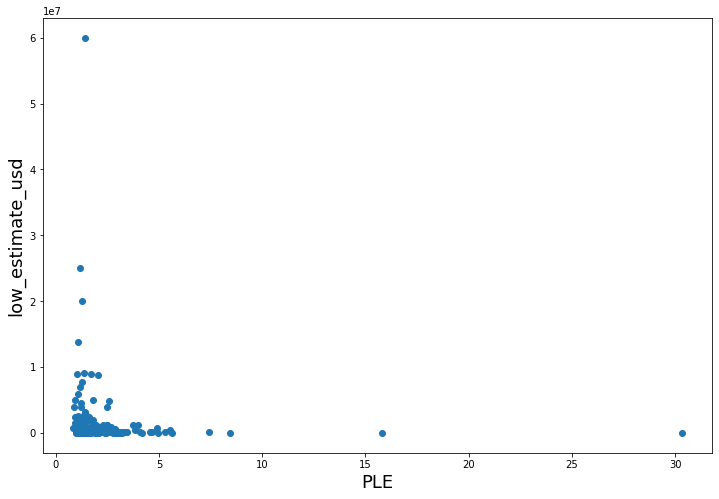

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X, y)
#ax.set_xlim(1, 5)
#ax.set_ylim(0, 3000000);
ax.set_xlabel("PLE",fontsize=18)
ax.set_ylabel("low_estimate_usd",fontsize=18)



There are several curve style that could fit the data, and so we're going to cycle thru them all using *funcspinner*.

"Funcspinner," an open-source curve fitting library. I created this library because it was challenging to locate a list of iterable non-linear functions  that could be used to fit non-linear data. The typical 2-factor textbook regression model does not accurately reflect the complexity of real life and so a data scientist may "spin through" the several functions in Funcspinner to see which one best describes the underlying data. 

more about funcspinner here
https://github.com/sjosephnyc1987/funcspinner

Our plan here is to spin through a few different non-linear functions and then check for the quality of fit using "standard error". We append each model's Standard Error into a list and see if any of them produce a number significantly better than the linear fit.


In [ ]:

#non-linear regression using funcspinner.

#--------cycling through a bunch of functios for non-linear regression------

list_of_functions = ["simpleLinear",	"quadratic",	"cubic",	"saturationGrowthRate",	"simpleExponential",	
                     "simplePower",		"michaelisMenten",	"reciprocal",	
                     "bleasdaleNelder",	"farazdagiHarris",	"holliday",	"exponential",	"threeParameterLogistic",	
                     "gompertz",	"weibull",		
                     "exponential1",	"exponential2",	"normal",	"lognormal",	"exponentialVariation",	"michaelisMenten2",	
                     "michaelisMenten3",	"linearLinear",	"linearQuadratic",		"quadraticQuadratic",	"linear3",	
                     "gompertz2",	"hill2",	"sum3Exponentials",	"gaussian",]

#results matrix that holds the standard error results for each model.
results_matrix = pd.DataFrame(columns=['function_name', 'standard_error'])


for functionname in list_of_functions:
        
    #get the function from the funcspinner class.
    objective_function = funcspinner.function_return(functionname)
    
    #if we want to see what's in the function returned
    import inspect
    #print(inspect.getsource(objective_function))
    
    # do the actual curve fit
    fit_paramsL, covariances = curve_fit(objective_function, xx, yy, maxfev=500000)

    #for printing out the results.
    coeffs = ["a","b","c","d","e","f","g","h","i","j","k"]
    
    i=0
    for coeff in fit_paramsL:
        #print(coeffs[i], "=" , coeff)
        i = i+1
    
    
    x_monotonic = np.arange(min(xx),max(xx),1)
    y_fit = objective_function(x_monotonic,*fit_paramsL)
    
    
    #to calulate the standard error
    #---------------------------------
    y_expected = objective_function(np.array(xx),*fit_paramsL)
    
    residuals = yy - y_expected
    squaresumofresiduals = np.sum(residuals**2)
    std_error = np.sqrt(squaresumofresiduals/len(y_expected))
    print("standard error from the ",functionname , "model = " ,str(round(std_error,2)))
    
    results_matrix = results_matrix.append({'function_name':functionname , 'standard_error': str(round(std_error,2))}, ignore_index=True)
 


In [ ]:
print(results_matrix.sort_values(by=['standard_error']))

             function_name standard_error
18               lognormal     4263934.38
29                gaussian     4800647.54
15            exponential1     4800960.42
16            exponential2     4824983.49
4        simpleExponential     4825649.11
19    exponentialVariation     4825649.11
28        sum3Exponentials     4825649.11
2                    cubic      4826399.4
5              simplePower     4831337.19
1                quadratic     4833368.98
24      quadraticQuadratic     4833368.98
6          michaelisMenten     4844968.63
21        michaelisMenten3     4844968.63
20        michaelisMenten2     4844968.63
3     saturationGrowthRate     4844968.63
25                 linear3     4852606.32
22            linearLinear     4852606.32
0             simpleLinear     4852606.32
17                  normal      4852715.1
13                gompertz     4867280.65
12  threeParameterLogistic     4867280.65
26               gompertz2     4867280.65
11             exponential     486

It appears that we dont have too much to write home about. The lognormal curve has a slightly better SE but even this is not very remarkable.

It appears that there's no real strong connection between the 2 variables.